# Visualisation of post and comments structure

#### 1. Documentation
- <>

#### 2. Examples
- <>

#### Libraries

In [1]:
#database management
import sqlite3
import pandas as pd
import numpy as np 
# networks
import networkx as nx
import networkx.algorithms.community as nxcom

#clustering
import markov_clustering as mc

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [2]:
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

## 1. Extracting data

In [3]:
# 1. Extracting and preparing the dataset:
conn = sqlite3.connect('Data/trump_election.db')
# 2. Full dataset
df_trump = pd.read_sql('''SELECT author, parent_author, month
                    FROM Reddit''', conn) 
#AVG( (centrality_betweeness + centrality_closeness + centrality_degree + centrality_eigenvector + centrality_page_rank)/5 ) AS centrality_score
df_trump

,author,parent_author,month
0,Aegisflame,iamafanofsecretriver,1
1,LucidicShadow,cuntipede,1
2,cuntipede,LucidicShadow,1
3,tacosaladchupacabra,JeffKSkilling,1
4,LucidicShadow,cuntipede,1
...,...,...,...
4496234,citizenjack,mikelo22,12
4496235,sedgwickian,mikelo22,12
4496236,desert_creature,mikelo22,12
4496237,AutoModerator,mikelo22,12


## 1. Most active user graph

In [4]:
def set_node_community(G, communities):
    node_color = []
    node_community = {}
    for i, com in enumerate(communities):
        for v in com:
            G.nodes[v]['community'] = i + 1
            node_color.append(get_color(i))
            node_community[v] = i
    return node_color, node_community, G

In [5]:
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

In [61]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    low, high = 0.1, 0.9
    n=40
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [7]:
def data_prep(df_in):
    # quantity    
    print('------------------------------------')
    df_quantity=df_in[(~df_in['author'].isin(['[deleted]','None'])) & (~df_in['parent_author'].isin(['[deleted]','None']))].groupby(["author"]).size().reset_index(name="count").sort_values("count",ascending=False)
    print(df_quantity.describe(include='all'))
    
    # quality    
    print('------------------------------------')
    df_quality=df_in[(~df_in['author'].isin(['[deleted]','None'])) & (~df_in['parent_author'].isin(['[deleted]','None']))].groupby(["author", "parent_author"]).size().reset_index(name="count").sort_values("count",ascending=False)
    print(df_quality.describe(include='all'))   
    return df_quantity, df_quality

In [8]:
df1,df2=data_prep(df_trump)

------------------------------------
          author         count
count     292582  292582.00000
unique    292582           NaN
top     MookyOne           NaN
freq           1           NaN
mean         NaN      13.05971
std          NaN      45.02546
min          NaN       1.00000
25%          NaN       1.00000
50%          NaN       2.00000
75%          NaN       8.00000
max          NaN    3182.00000
------------------------------------
           author         parent_author         count
count     3107051               3107051  3.107051e+06
unique     292582                199815           NaN
top     atl2ptown  PoliticsModeratorBot           NaN
freq         1627                 11959           NaN
mean          NaN                   NaN  1.229795e+00
std           NaN                   NaN  8.498101e-01
min           NaN                   NaN  1.000000e+00
25%           NaN                   NaN  1.000000e+00
50%           NaN                   NaN  1.000000e+00
75%           

In [9]:
import community as community_louvain

In [62]:
def graph_plot(df_in):
    # data
    df_in['weights']=df_in['count']/df_in['count'].sum()
    
    df_graph=df_in.loc[df_in['count']>8]
    print(len(df_in))
    print(len(df_graph))    
    
    # graph
    G_all=nx.from_pandas_edgelist(df_graph, source='parent_author', target='author', create_using=nx.DiGraph())
    # Create a subgraph of G consisting only of this component:
    sub_list = max(nx.weakly_connected_components(G_all), key=len)
    G = G_all.subgraph(sub_list)

    # determine communities
    H=nx.Graph(G)   
    print("===============================================================")
    partition1=sorted(nxcom.greedy_modularity_communities(H), key=len, reverse=True) 
    print('CNM coverage:',    nxcom.coverage(H, partition1))
    print('CNM performance:', nxcom.performance(H, partition1))    
    print("CNM number of communities:", len(partition1) )
    print("-------------------------------------------------------------")   
    
    partition2=sorted(nxcom.asyn_lpa_communities(H), key=len, reverse=True) 
    print('LPA coverage:',    nxcom.coverage(H, partition2))
    print('LPA performance:', nxcom.performance(H, partition2))    
    print("LPA number of communities:", len(partition2) )
    print("-------------------------------------------------------------")   

    partition3=sorted(nxcom.asyn_fluidc(H, 5), key=len, reverse=True) 
    print('Fluids5 coverage:',    nxcom.coverage(H, partition3))
    print('Fluids5 performance:', nxcom.performance(H, partition3))           
    print("Fluids5 number of communities:", len(partition3) )
    print("-------------------------------------------------------------")   
 
    partition4=sorted(nxcom.asyn_fluidc(H, 10), key=len, reverse=True) 
    print('Fluids10 coverage:',    nxcom.coverage(H, partition4))
    print('Fluids10 performance:', nxcom.performance(H, partition4))         
    print("Fluids10 number of communities:", len(partition4) )
    print("-------------------------------------------------------------")   
        
    partition5=sorted(nxcom.asyn_fluidc(H, 15), key=len, reverse=True) 
    print('Fluids15 coverage:',    nxcom.coverage(H, partition5))
    print('Fluids15 performance:', nxcom.performance(H, partition5))       
    print("Fluids15 number of communities:", len(partition5) )

    print("===============================================================")
    
    communities = partition1

    
    # Set node and edge communities
    node_color, node_community, G = set_node_community(G, communities)
    set_edge_community(G)

    # Set community color for nodes
    node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

    # Set community color for internal edges
    external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
    internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
    internal_color = [get_color(G.edges[e]['community']) for e in internal]    
        
    # plot
    fig = plt.figure(figsize=(50, 50))
    # node position
    pos = nx.nx_pydot.graphviz_layout(G, prog='sfdp')
            # Other options:
                # a) dot - filter for drawing directed graphs 
                # b) neato - filter for drawing undirected graphs 
                # c) twopi - filter for radial layouts of graphs 
                # d) circo - filter for circular layout of graphs 
                # e) fdp - filter for drawing undirected graphs 
                # f) sfdp - filter for drawing large undirected graphs 
                # g) patchwork - filter for tree maps 
    print('--------------------------------------------')           
    print(nx.info(G))
    print(nx.is_weakly_connected(G))
    print(nx.is_strongly_connected(G))
    print("Network density:", nx.density(G))
    print("Clustering: ",nx.average_clustering(G))
    print("Transitivity: ",nx.transitivity(G))   
    print("triangles: ",len(nx.triangles(H)))
    print("diameter: ",nx.diameter(H))
    print("global_efficiency: ",nx.global_efficiency(H))    
    print("overall_reciprocity: ",nx.overall_reciprocity(G))  
    print("average_shortest_path_length: ",nx.average_shortest_path_length(G))  
    print("s_metric: ",nx.s_metric(G, normalized=False))
    print("number_attracting_components: ",nx.number_attracting_components(G))   
    print("wiener_index: ",nx.wiener_index(H))   
    print('--------------------------------------------')
    # Draw external edges
    nx.draw_networkx(G, pos=pos, node_size=0, edgelist=external, style="dashed", edge_color="lightgrey", with_labels=False)
    # Draw nodes and internal edges
    nx.draw_networkx(G, pos=pos, node_color=node_color, edgelist=internal, edge_color=internal_color, with_labels=False)

3107051
5447
CNM coverage: 0.952650540401441
CNM performance: 0.9526885823202215
CNM number of communities: 39
-------------------------------------------------------------
LPA coverage: 0.7503860010293361
LPA performance: 0.9781730265468552
LPA number of communities: 399
-------------------------------------------------------------
Fluids5 coverage: 0.9778692743180648
Fluids5 performance: 0.758380561321707
Fluids5 number of communities: 5
-------------------------------------------------------------
Fluids10 coverage: 0.9644879053010808
Fluids10 performance: 0.8345077612591641
Fluids10 number of communities: 10
-------------------------------------------------------------
Fluids15 coverage: 0.970663921770458
Fluids15 performance: 0.8590762333826908
Fluids15 number of communities: 15
--------------------------------------------
Name: 
Type: DiGraph
Number of nodes: 1852
Number of edges: 3010
Average in degree:   1.6253
Average out degree:   1.6253
True
False
Network density: 0.00087804

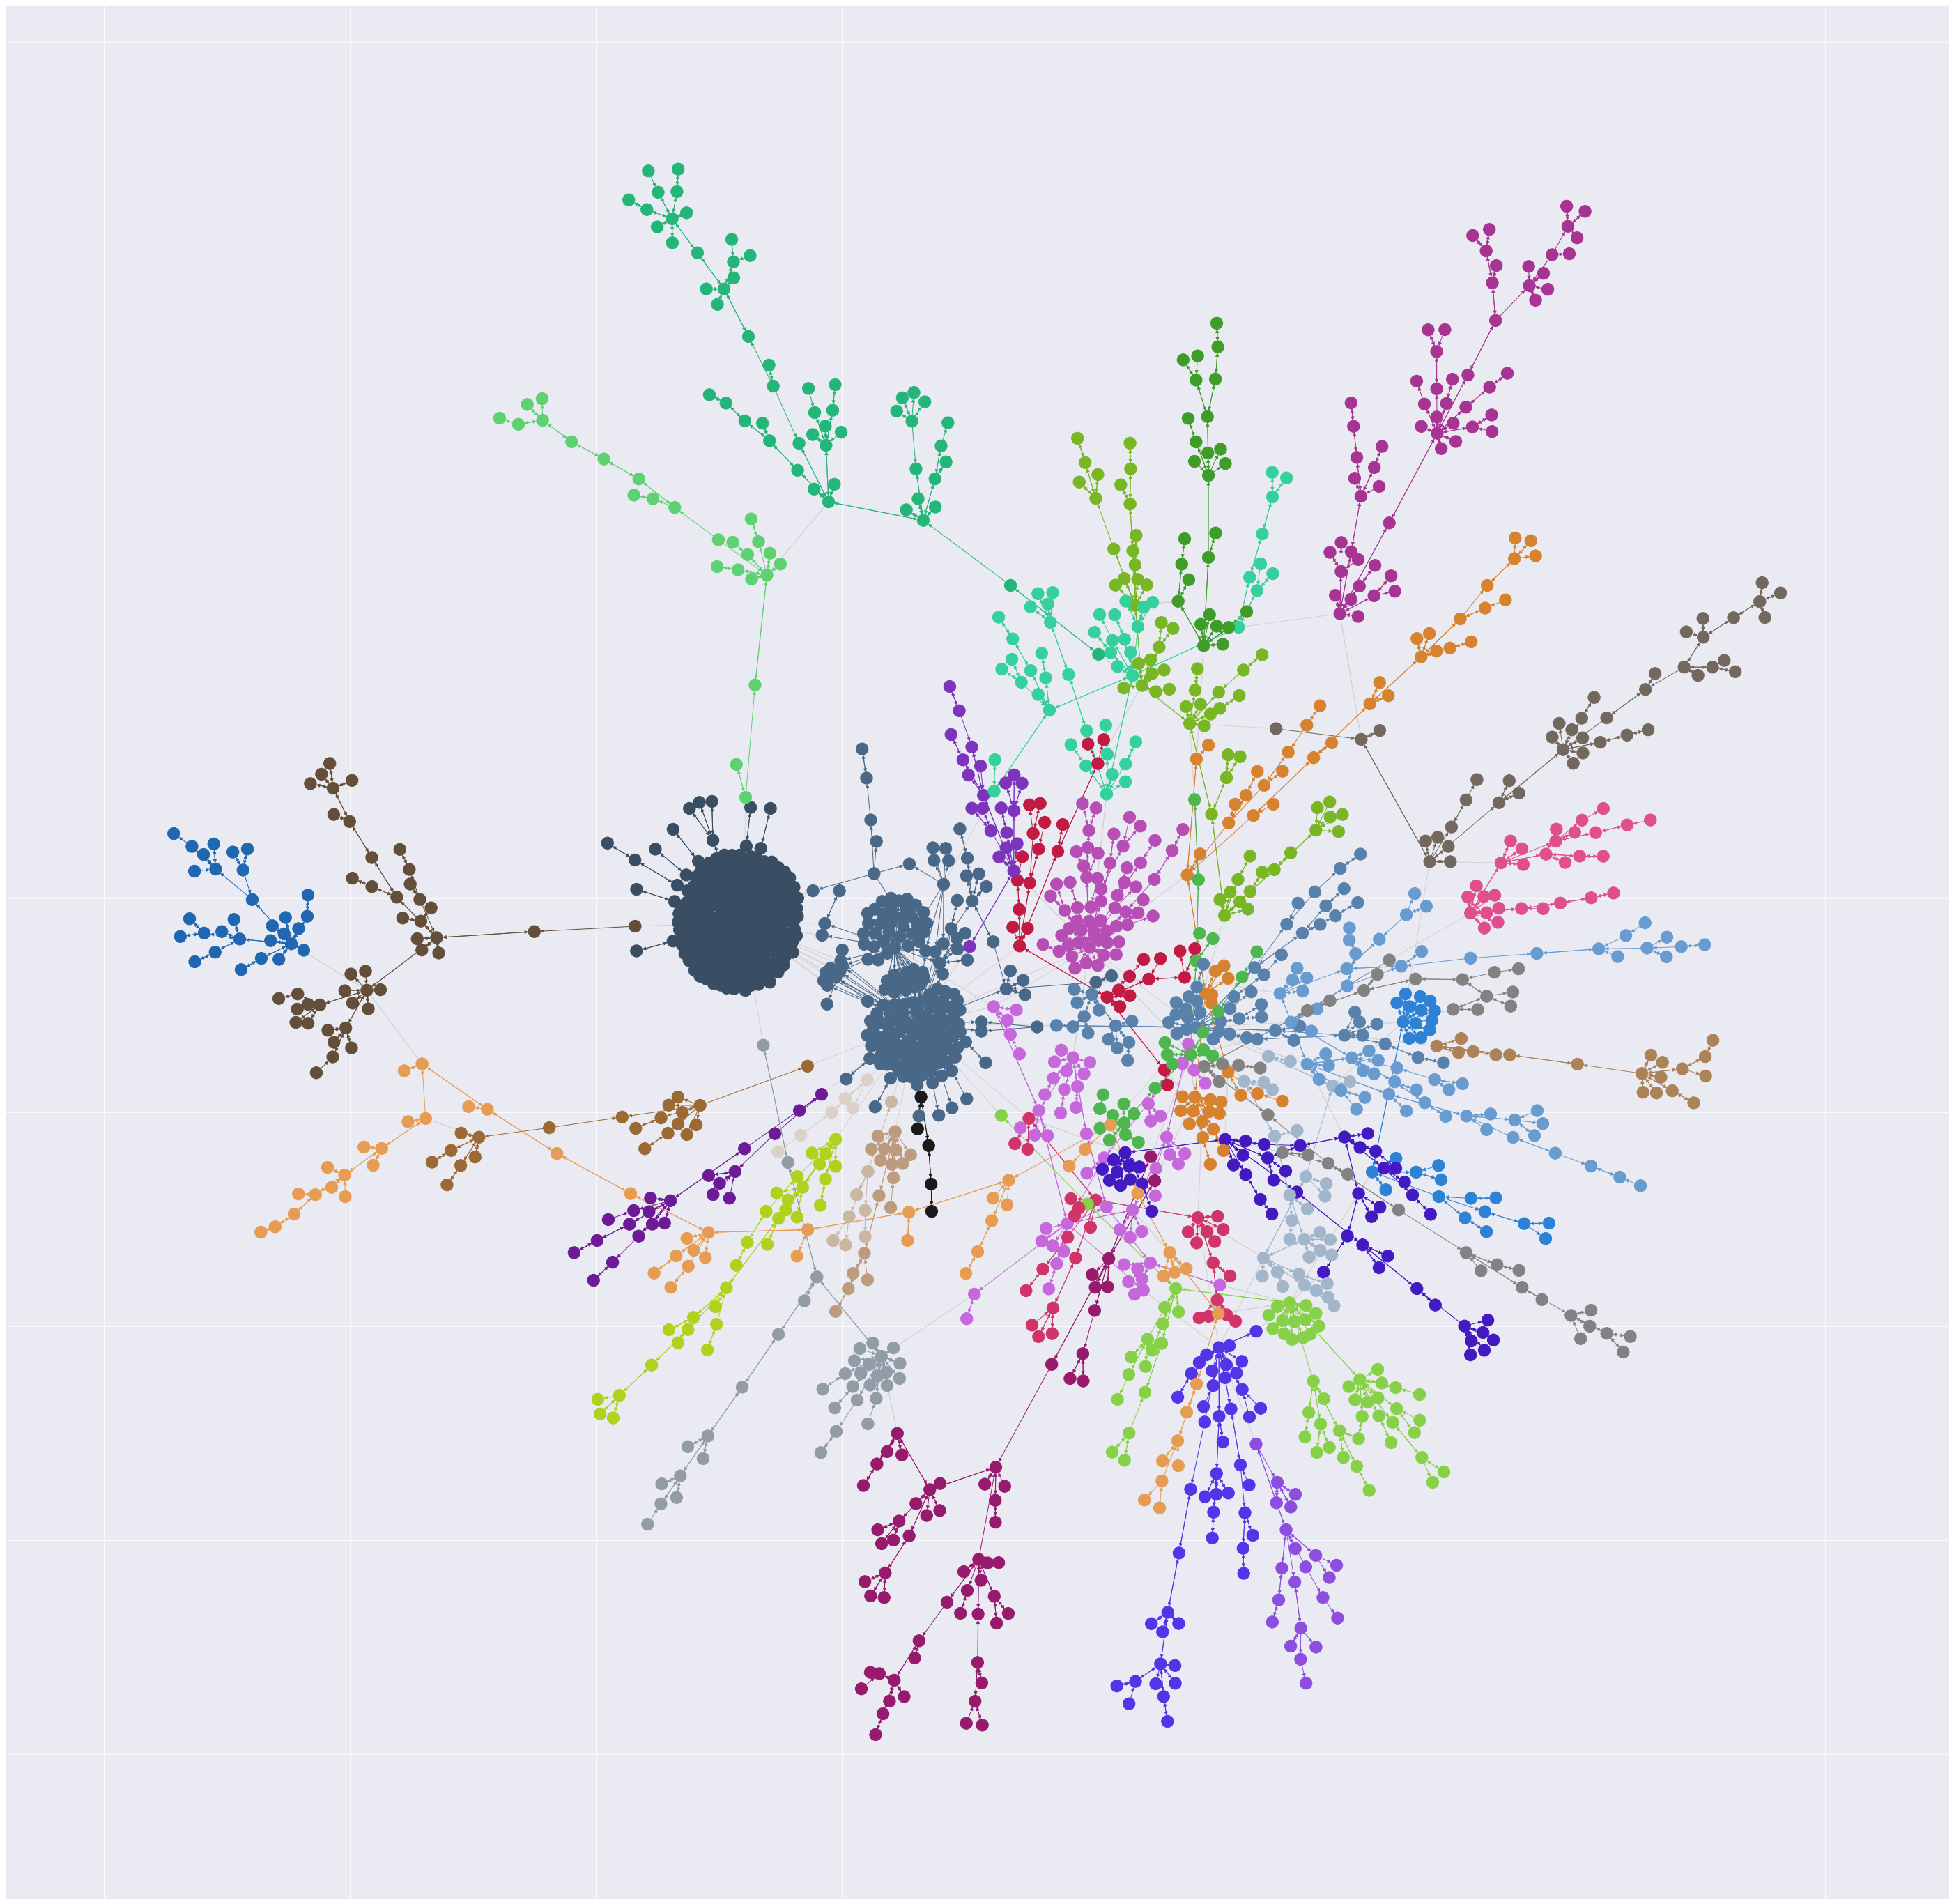

In [63]:
graph_plot(df2)
plt.savefig(r'Visualisations/1_user_plot.png', bbox_inches='tight')
plt.show()

The method greedy_modularity_communities() tries to determine the number of communities appropriate for the graph, and groups all nodes into subsets based on these communities. Unlike the centrality functions, the above code will not create a dictionary. Instead it creates a list of special “frozenset” objects (similar to lists). There’s one set for each group, and the sets contain the names of the people in each group. In order to add this information to your network in the now-familiar way, you must first create a dictionary that labels each person with a number value for the group to which they belong:

2) Community Coverage: In this section, we define a new
metric called desirable community coverage to measure the
number of users assigned to desirable communities, that
is, communities of size 4 to 150. Generally speaking, the
higher the desirable community coverage, the better the algorithm. Note that even Infomap, Multilevel, Eigenvector,
and FastGreedy all assign every single node in the graph
to a community, they do not provide 100% coverage in our
definition of desirable community coverage. Fig. 2 shows
the performance of each algorithm with regard to desirable
community coverage while taking the community size into
account

The reciprocity of a directed graph is defined as the ratio of the number of edges pointing in both directions to the total number of edges in the graph.

## 2. Comparison between Jan and Oct

In [28]:
def graph_stat(df_in):
    # graph
    G_di=nx.from_pandas_edgelist(df_in, source='parent_author', target='author', create_using=nx.DiGraph())
    print(nx.info(G_di))
    print(nx.is_weakly_connected(G_di))
    print(nx.is_strongly_connected(G_di))
    for C in (G_di.subgraph(c).copy() for c in nx.weakly_connected_components(G_di)):
        print('--------------------------------------------')
        print("Network density:", nx.density(C))
        print("Clustering: ",nx.average_clustering(C))
        print("Transitivity: ",nx.transitivity(C))

In [29]:
df_jan=df_trump.loc[df_trump['month']==1]
df_oct=df_trump.loc[df_trump['month']==10]

In [30]:
graph_stat(df_jan)

Name: 
Type: DiGraph
Number of nodes: 42060
Number of edges: 154087
Average in degree:   3.6635
Average out degree:   3.6635
True
False
--------------------------------------------
Network density: 8.710393773879926e-05
Clustering:  0.043614671833677746
Transitivity:  0.002562992263902311


In [31]:
graph_stat(df_oct)

Name: 
Type: DiGraph
Number of nodes: 75251
Number of edges: 336907
Average in degree:   4.4771
Average out degree:   4.4771
True
False
--------------------------------------------
Network density: 5.949647759120739e-05
Clustering:  0.06428519537776115
Transitivity:  0.0016696838585735455


On July 19, 2016, Trump and his running mate, Indiana Governor Mike Pence, were officially nominated as the Republican presidential and vice presidential candidates at the Republican National Convention.[8] Trump and Pence went on to defeat the Democratic ticket of Hillary Clinton and Tim Kaine in the general election on November 8, 2016.[9]

1) shortest path length


Networks can be characterized according to their distribution of shortest path lengths.

The karate club and internet networks both have very small path lengths, while the
electrical network has much larger lengths. Social networks tend to have short paths,
known as the small world phenomenon. Infrastructure networks such as the electrical grid
have longer paths because high voltage lines are costly, and are only used to connect
nearby points. While the internet network is also infrastructural, it is composed of
interconnected long-distance links that help information move quickly across long
distances. These redundant long-distance links result in smaller path lengths than other
infrastructure networks.

2) Dencity
- <https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python>

The output of density is a number, so that’s what you’ll see when you print the value. In this case, the density of our network is approximately 0.0248. On a scale of 0 to 1, not a very dense network, which comports with what you can see in the visualization.8 A 0 would mean that there are no connections at all, and a 1 would indicate that all possible edges are present (a perfectly connected network): this Quaker network is on the lower end of that scale, but still far from 0.

Resilience is the ability of a system to withstand errors and attacks. In an electrical grid, for
example, resilience would mean keeping power flowing when a transmission line or
generator broke down. In traffic, it could mean the ability to reroute cars when a street is
closed due to an accident.

Resilience is fundamentally a network property because it is usually achieved with
redundant paths. When one path is no longer available, the others can still be used.
The simplest (and crudest) measure of resilience is the density of a network: the fraction of
possible edges that exist. The more edges present in a network, the more redundant paths
exist between its nodes. The following code uses the density() function to calculate this
value for the example networks:

A network is generally considered sparse if the number of edges is close to N (the number
of nodes), and dense if the number of edges is close to N2.

3) Clustering

The level of clustering or transitivity in a network can be quantified using triangles, just as
the transitivity was quantified for individual nodes in Chapter 5, The Small Scale – Nodes
and Centrality. These measures describe, overall, how common triangles are within a
network.

An alternative approach is to average the local clustering coefficient (described in Chapter
5, The Small Scale – Nodes and Centrality) over all nodes. This measure is sometimes called
the global clustering coefficient. In NetworkX, it is calculated using the
average_clustering() function, as in the following example:

4) Transitivity

The simplest measure of large-scale clustering is transitivity: the fraction of possible
triangles that are present.

5) Minimum cuts

More sophisticated measures of resilience are based on the concept of minimum cuts. A
minimum cut or min-cut is the number of nodes (or edges) that need to be removed to
separate the network into two unconnected parts. Minimum cuts can be found either
between two specific nodes, or over all pairs of nodes.
In NetworkX, the minimum cut between two nodes is found using the
minimum_st_node_cut() function. Note that this function is in the connectivity
package and needs to be imported separately in addition to the base networkx package.
The following code finds the minimum node cut between Mr. Hi and John A. in the karate
club network:

Minimum cuts can be used to define connectivity measures for entire networks. These
measures are very useful for quantifying the resilience of a network.
The node connectivity is the smallest min-cut over all node pairs. The edge connectivity is
defined similarly. The actual node and edge cuts can be found using the connection
package:

The connectivity can be calculated using the node_connectivity() and
edge_connectivity() functions without specifying source and target nodes. The
following example finds the node connectivity for the three example networks:

It seems that all of these networks can be divided into disconnected parts by the removal of
a single node! The next time your power goes out, you can blame the low connectivity of
the electrical grid.
The preceding connectivity measure finds the size of the smallest min-cut, but removing
that won't affect all the paths in the network. After that node or edge has been removed, the
network will be divided, but within each half, nodes are still connected to each other.
A better measure of reliability can be found by averaging the connectivity over all nodes or
edges using the average_node_connectivity() and average_edge_connectivity()
functions. Note that these values can take a long time to calculate, even for small networks.
The following code calculates the average node connectivity of the example networks:

## 5. User activity (donor/recipient)

In [ ]:
def author_plot(df_in_1, df_in_2):
    # data 1
    x1=df_in_1['author'].value_counts().to_frame().reset_index()
    y1=df_in_1['parent_author'].value_counts().to_frame().reset_index()
    df_1=pd.merge(x1, y1, on="index")
    df_1["user_activity"]=(df_1["author"]/(df_1["author"]+df_1["parent_author"])).round(2)
    df_1=df_1[~df_1['index'].isin(['[deleted]','None'])]\
            .sort_values(by=['user_activity'], ascending=False)\
            .rename(columns={"author": "recipient", "parent_author": "donor", "index": "author"})
    print(len(df_1))
    # data 2
    x2=df_in_2['author'].value_counts().to_frame().reset_index()
    y2=df_in_2['parent_author'].value_counts().to_frame().reset_index()
    df_2=pd.merge(x2, y2, on="index")
    df_2["user_activity"]=(df_2["author"]/(df_2["author"]+df_2["parent_author"])).round(2)
    df_2=df_2[~df_2['index'].isin(['[deleted]','None'])]\
            .sort_values(by=['user_activity'], ascending=False)\
            .rename(columns={"author": "recipient", "parent_author": "donor", "index": "author"})
    print(len(df_2))
    # subplot grid
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'wspace': .15})
    
    # plot 1    
    axes[0].hist(df_1["user_activity"], bins=20, facecolor='blue', alpha=0.5)
    #sns.distplot(df_1["user_activity"], bins=20, ax=axes[0])
    #axes[0].set_xlim(0, 1) 
    axes[0].set_ylim(0, 51000) 
    axes[0].set_title('Donor/recipient relation in 2012',fontsize=15)
    axes[0].set_xlabel("User score",fontsize=10)
    #axes[0].set_ylabel("Percentage of comments",fontsize=10)
    
    # plot 2
    axes[1].hist(df_2["user_activity"], bins=20, facecolor='blue', alpha=0.5)
    #sns.distplot(df_2["user_activity"], bins=20, ax=axes[1])
    #axes[0].set_xlim(0, 1) 
    axes[1].set_ylim(0, 51000) 
    axes[1].set_title('Donor/recipient relation in 2016',fontsize=15)
    axes[1].set_xlabel("User score",fontsize=10)
    #axes[1].set_ylabel("Percentage of comments",fontsize=10)


In [ ]:
author_plot(df_obama,df_trump)
plt.savefig(r'Visualisations/6_donor.png', bbox_inches='tight')
plt.show()